# (Ford GoBike - Communicate Data Findings)
## by (Moheb Maher)

## Understanding the Context

> - Bay Wheels is a regional public bicycle sharing system in California's San Francisco Bay Area.
> - It was established as Bay Area Bike Share in August 2013.
> - As of January 2018, the Bay Wheels system had over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose.
> - In June 2017 the system was officially re-launched as Ford GoBike in a partnership with Ford Motor Company.
> - The system was renamed to Bay Wheels in June 2019.
> - The system is expected to expand to 7,000 bicycles around 540 stations in San Francisco, Oakland, Berkeley, Emeryville, and San Jose.

## Investigation Overview

> - Who are Ford GoBike’s customers?
> - What are the characteristics of Customers vs. Subscribers?
> - When is the service often used? (rush hours - weekdays vs. weekends)
> - What is the average ride duration?
> - Which are the famous start and and destination station?
> - Which are the famous routes?

## Dataset Overview

> - The dataset used for this exploratory analysis consists of Bay Wheels's trip data for individual rides made in a bike-sharing system covering the greater San Francisco Bay area from Jan 2018 to Dec 2018.
> - The original dataset can be found in the download here:
>> https://www.kaggle.com/mohebmhanna/udacity-ford-gobike-communcate-data-findings.

In [1]:
# Import all necessary packages:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
from pandas.api.types import CategoricalDtype
from geopy.distance import geodesic
import datetime as dt

# suppressing warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# Creating & setting a customized palette:
custom_palette = ['#118ab2', '#ef476f', '#06d6a0', '#ffd166', '#073b4c']
sns.set_palette(custom_palette)

# Defining our main colors:
blue = custom_palette[0]
red = custom_palette[1]
green = custom_palette[2]

In [3]:
# load in the dataset into a pandas dataframe:
df = pd.read_csv('./output/2018-fordgobike-tripdata-ready-sample.csv')

In [4]:
# Putting hours in the correct order:
hours = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
         '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '00']

# Creating an ordered hours CategoricalDtype:
hours_cat = CategoricalDtype(categories=hours, ordered=True)

# Putting weekdays in the correct order:
weekdays = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Creating an ordered weekdays CategoricalDtype:
weekdays_cat = CategoricalDtype(categories=weekdays, ordered=True)

# Putting months in the correct order:
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

# Creating an ordered months CategoricalDtype:
months_cat = CategoricalDtype(categories=months, ordered=True)

## Who are Ford GoBike’s customers? [1/3]
### (User type and gender)

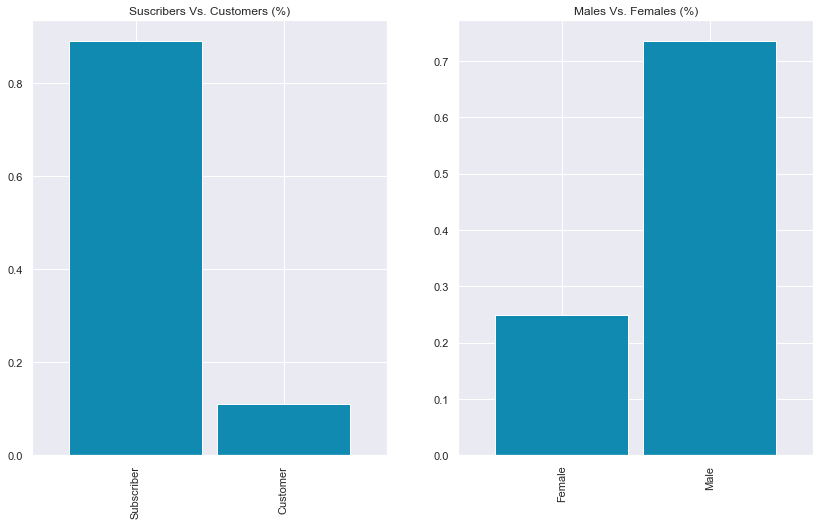

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

ax1.set_title('Suscribers Vs. Customers (%)')
df['user_type'].value_counts(normalize=True).plot.bar(color=blue, width=0.9, ax=ax1)

ax2.set_title('Males Vs. Females (%)')
labels = ['Female', 'Male']
gens = df['member_gender'].value_counts(normalize=True).loc[labels]
gens.plot.bar(color=blue, tick_label=labels, width=0.9, ax=ax2);

> - Since there is no user id column, we can't guarantee that these counts represent unique individuals.
> - Subscribers usually use any service more often, so it makes sense that subscribers and cusomers should be weighted differently and it will be crucial to segment our audience later on.
> - All we can conclude that:
>> 1. The service is being used by subscribers about 8 times more often than ordinary customers.
>> 2. The service is being used by males about 3 times more often than females.

### Who are Ford GoBike’s customers?  [Part 2/3]
### (Age groups)

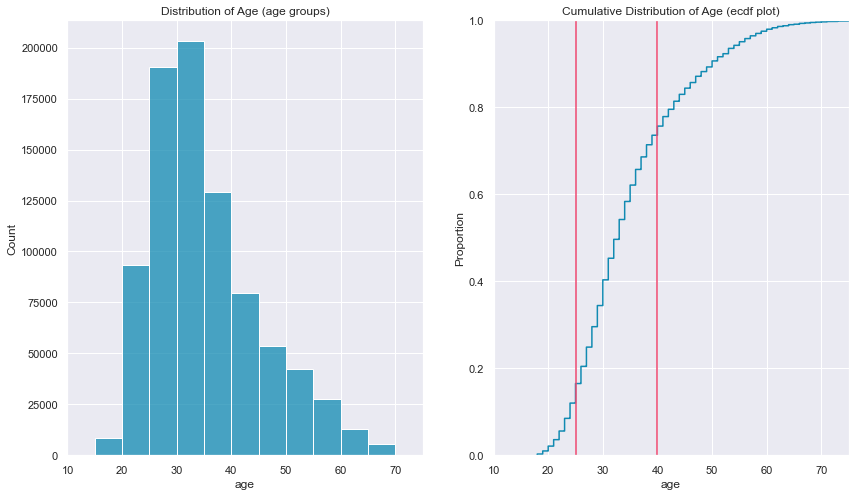

In [6]:
# Plotting the distribution of age groups after some fine-tuning:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

ax1.set_title('Distribution of Age (age groups)')
start, stop, step = 10, 70, 5 
bin_edges = np.arange(start, stop+step, step)
ax1.set_xlim(start, stop+step) # Limits are based on summary stats
sns.histplot(data=df, x='age', stat='count', bins=bin_edges, color=blue, ax=ax1)

ax2.set_title('Cumulative Distribution of Age (ecdf plot)')
ax2.set_xlim(start, stop+step) # Limits are based on summary stats
sns.ecdfplot(data=df, x='age', stat='proportion', color=blue, ax=ax2)
ax2.axvline(25, color=red)
ax2.axvline(40, color=red);

> - The histogram is skewed to the right which makes sense because riding a bike is presumed to be more difficult in older ages.
> - The age group around 30 years old is the most common pattern.
> - About 60% of bike rides were done by people aged around 25-40 years.
> - Most bike rides were done by age groups 30-35 > 25-30 > 35-40.
> - The presence of ages older than 60 years may suggest wrong enteries (ages greater than 100 were dropped at the early cleaning phase).

## Who are Ford GoBike’s customers? [3/3]
### (Age Vs. user type Vs. gender)

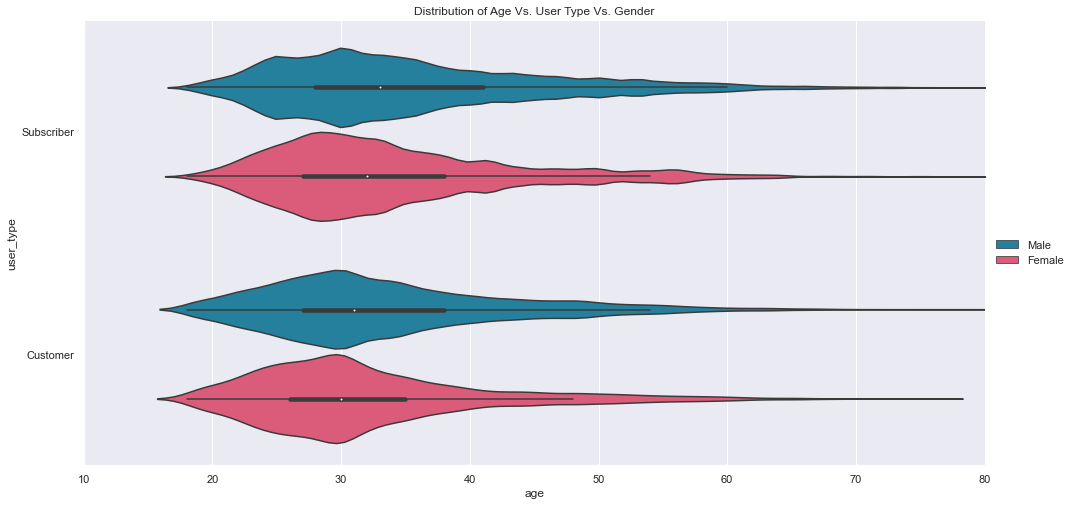

In [7]:
# Plotting the distribution of age Vs. user type Vs. gender (boxplot):
g = sns.FacetGrid(data=df, xlim=(10, 80), height=7, aspect=2)
g.map_dataframe(sns.violinplot, y='user_type', x='age', hue='member_gender',
                palette={'Male': blue, 'Female': red}, hue_order=['Male', 'Female'])

g.set(title='Distribution of Age Vs. User Type Vs. Gender')
g.add_legend();

> - The distribution is nearly the same in both groups.
> - The IQR of males is slighly shifted to the right.
> - The violin plot in the male group has a longer tail (more right-skewed).
> - The age of male subscribers may have 2 peaks.

## When is the service often used? [1/4]
### (Trip counts Vs. hours)

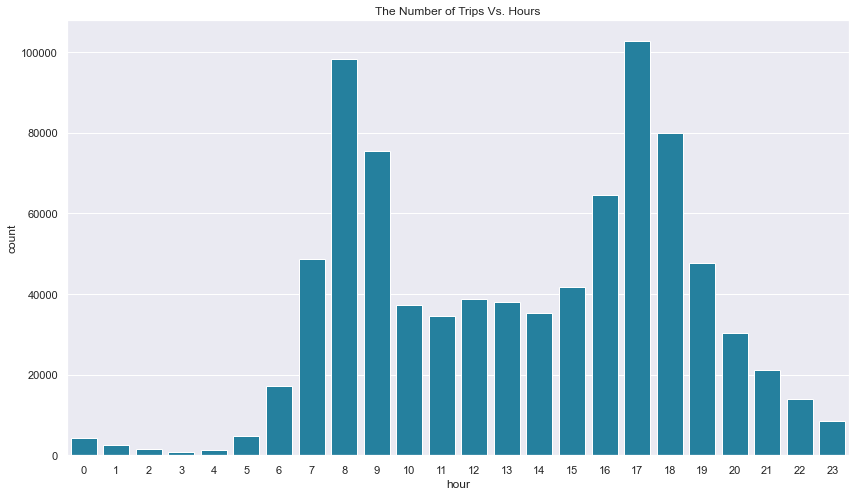

In [8]:
# Plotting the trip counts Vs. hours:
plt.figure(figsize=(14, 8))
plt.title('The Number of Trips Vs. Hours')
g = sns.countplot(data=df, x='hour', color=blue);

> - The distribution here is bimodal, suggesting  2 rush hours: 7am : 9am & 4pm : 7pm.
> - The rides reach their nadir between 1-4 am.

## When is the service often used? [2/4]
### (Trip counts Vs. weekdays)

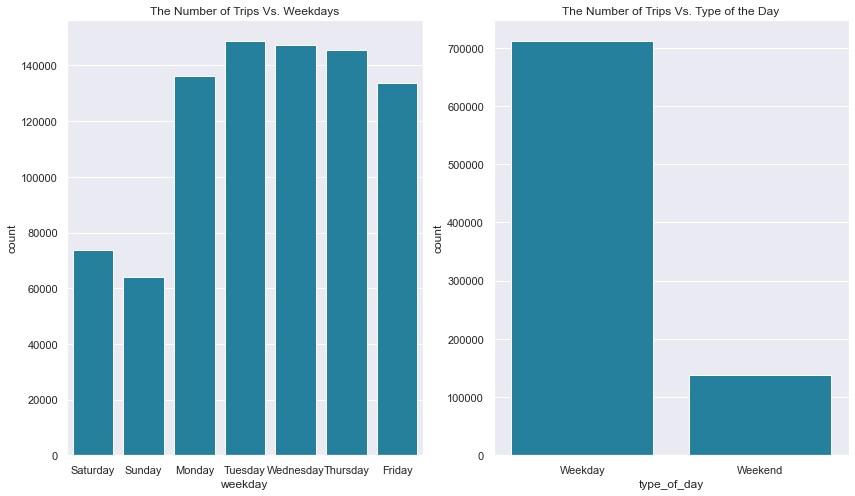

In [9]:
# Plotting trip counts Vs.weekdays and the type of the day:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

ax1.set_title('The Number of Trips Vs. Weekdays')
sns.countplot(data=df, x='weekday', color=blue,order=weekdays , ax=ax1)

ax2.set_title('The Number of Trips Vs. Type of the Day')
sns.countplot(data=df, x='type_of_day', color=blue, ax=ax2);

> - A common pattern is that weekdays tend to witness more rides than weekends.

## When is the service often used? [2/4]
### (Trip counts Vs. hours Vs weekdays)

In [10]:
# Creating a pivot table for hours Vs weekday:
hrs_vs_wkdays_trip_counts = df.pivot_table(index='hour', columns='weekday', values='start_station_name',
                                           aggfunc='count', fill_value=0)[weekdays]

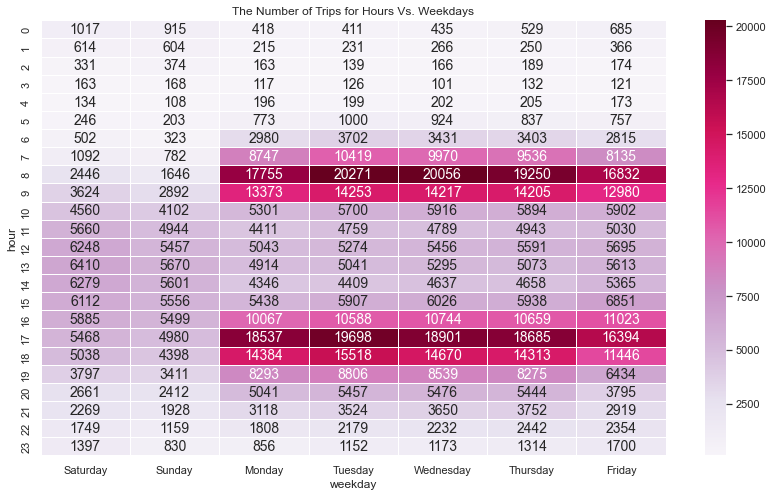

In [11]:
# Plotting a heatmap for hours Vs weekday:
plt.figure(figsize=(14, 8))
g = sns.heatmap(data=hrs_vs_wkdays_trip_counts, cmap='PuRd', linewidth=1,
                annot=True, fmt='.0f', annot_kws={'fontsize': 14})
g.set(title='The Number of Trips for Hours Vs. Weekdays');

> - In weekdays, the majority of rides occur at the 2 formerly mentioned rush hours.
> - In weekends, most rides occur between 8 am - 8 pm.

## When is the service often used? [4/4]
### (Trip counts Vs. months)

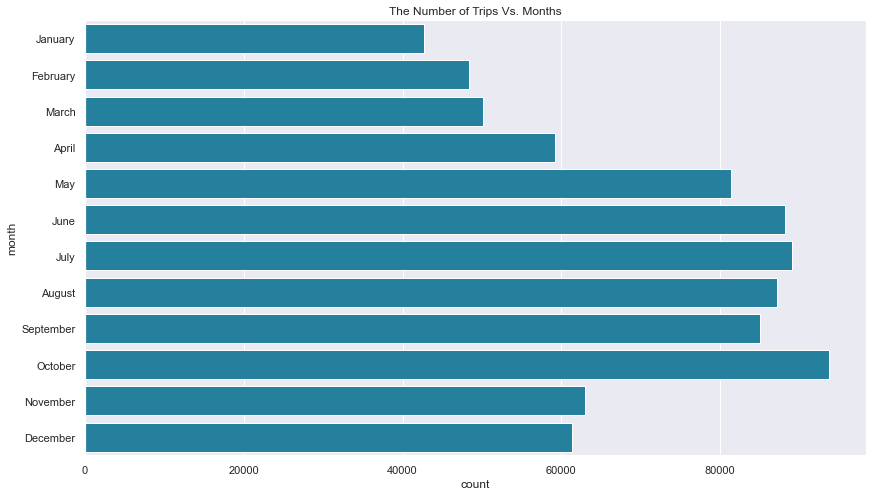

In [12]:
# Plotting trip counts Vs. months:
plt.figure(figsize=(14, 8))
plt.title('The Number of Trips Vs. Months')
g = sns.countplot(data=df, y='month', color=blue);

> - The common pattern here is that winter months witness less rides.

## What is the average ride duration? [1/2]
### (Distribution of duration)

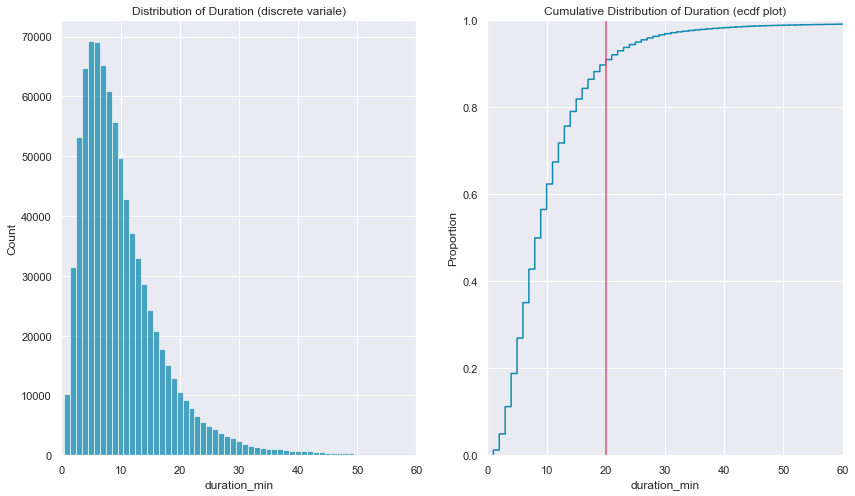

In [13]:
# Plotting the distribution of duration (discrete variable - cumulative frequency):
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

ax1.set_title('Distribution of Duration (discrete variale)')
ax1.set_xlim(0, 60) # Limits are based on summary stats
sns.histplot(data=df, x='duration_min', stat='count', discrete=True, color=blue, ax=ax1)

ax2.set_title('Cumulative Distribution of Duration (ecdf plot)')
ax2.set_xlim(0, 60) # Limits are based on summary stats
sns.ecdfplot(data=df, x='duration_min', stat='proportion', color=blue, ax=ax2)
ax2.axvline(20, color=red);

> - The distribution is skewed to the right suggesting that long rides are less common.
> - About 90% of the rides took less than 20 minutes.

## What is the average ride duration? [2/2]
### (Average duration Vs. user type Vs. type of the day)

In [14]:
# Capping the duration to the 99th percentile:
p_99 = df['duration_min'].quantile(0.99)
df_ = df.query("duration_min < = @p_99")

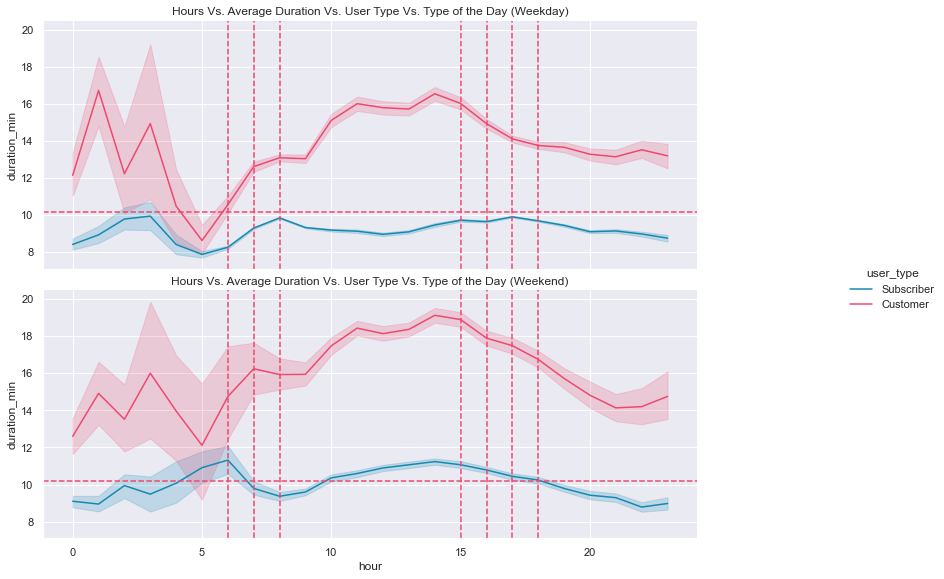

In [15]:
# Plotting hours Vs. average duration Vs. user type Vs. type of the day:
g = sns.relplot(kind='line', data=df_, x='hour', y='duration_min', estimator=np.mean, hue='user_type', row='type_of_day')

g.refline(y=df_['duration_min'].mean(), color=red)
for h in [6, 7, 8, 15, 16, 17, 18]:
    g.refline(x=h, color=red)
    
g.set_titles(row_template='Hours Vs. Average Duration Vs. User Type Vs. Type of the Day ({row_name})')
g.fig.set_size_inches(14, 8);

> - The average duration is generally higher for the customers group.
> - The duration is highly variable outside the rush hours.
> - The variation in duration is higher for the customers group than subscribers group.

## Which are the famous start and and destination station? [1/3]
### (Top 20 start stations)

In [16]:
# Filtering the top 20 start stations:
top_20_strt_st = df['start_station_name'].value_counts().head(20).index.to_list()
df_ = df.query("start_station_name in @top_20_strt_st")

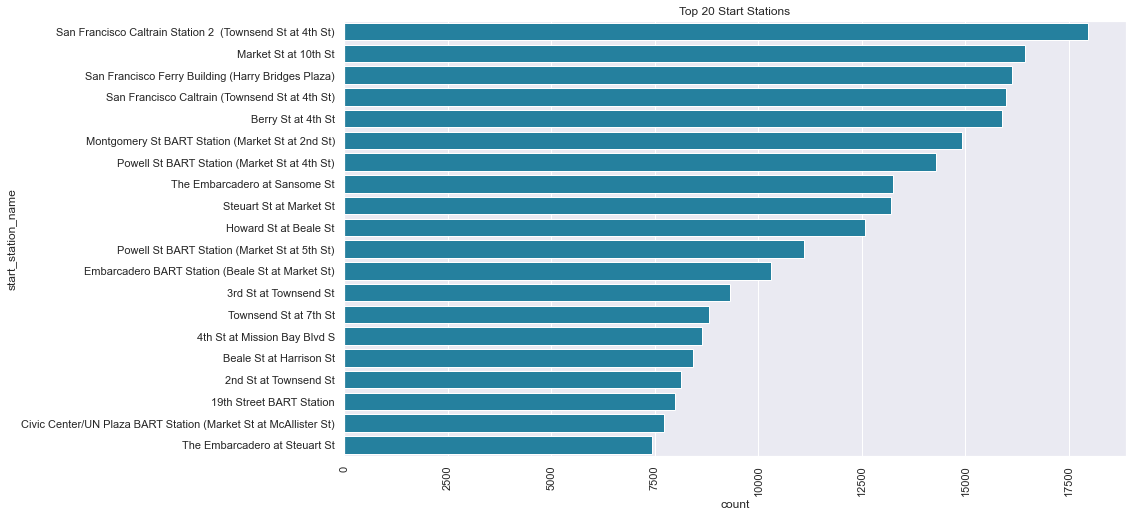

In [17]:
# Plotting the frequency of top 20 start stations:
plt.figure(figsize=(14, 8))
plt.title('Top 20 Start Stations')
plt.xticks(rotation=90)
g = sns.countplot(data=df_, y='start_station_name', color=blue, order=top_20_strt_st);

> - Top 10 start stations:
>> 1. San Francisco Caltrain Station 2  (Townsend St at 4th St).
>> 2. Market St at 10th St.
>> 3. San Francisco Ferry Building (Harry Bridges Plaza).
>> 4. San Francisco Caltrain (Townsend St at 4th St).
>> 5. Berry St at 4th St.
>> 6. Montgomery St BART Station (Market St at 2nd St).
>> 7. Powell St BART Station (Market St at 4th St).
>> 8. The Embarcadero at Sansome St.
>> 9. Steuart St at Market St.
>> 10. Howard St at Beale St.

## Which are the famous start and and destination station? [2/3]
### (Top 20 end stations)

In [18]:
# Filtering the top 20 end stations:
top_20_end_st = df['end_station_name'].value_counts().head(20).index.to_list()
df_ = df.query("end_station_name in @top_20_end_st")

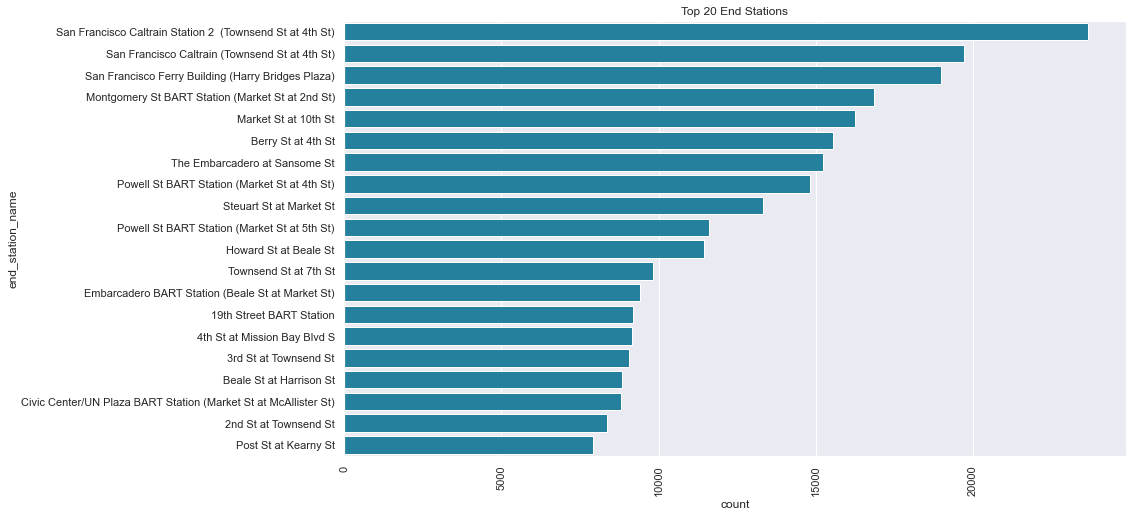

In [19]:
# Plotting the frequency of top 20 end stations:
plt.figure(figsize=(14, 8))
plt.title('Top 20 End Stations')
plt.xticks(rotation=90)
g = sns.countplot(data=df_, y='end_station_name', color=blue, order=top_20_end_st);

> - Top 10 end stations:
>> 1. San Francisco Caltrain Station 2  (Townsend St at 4th St).
>> 2. San Francisco Caltrain (Townsend St at 4th St).
>> 3. San Francisco Ferry Building (Harry Bridges Plaza).
>> 4. Montgomery St BART Station (Market St at 2nd St).
>> 5. Market St at 10th St.
>> 6. Berry St at 4th St.
>> 7. The Embarcadero at Sansome St.
>> 8. Powell St BART Station (Market St at 4th St).
>> 9. Steuart St at Market St.
>> 10. Powell St BART Station (Market St at 5th St).

## Which are the famous start and and destination station? [3/3]
### (Trip counts Vs. start station Vs. end stations)

In [20]:
# Creating a matrix for start stations Vs. end stations:
strt_end_st_trip_counts = df.pivot_table(index='start_station_name', columns='end_station_name',
                                         values='user_type', aggfunc='count', fill_value=0)

# Filtering the dataset:
top_10_strt_st = df['start_station_name'].value_counts().head(10).index.to_list()
top_10_end_st = df['end_station_name'].value_counts().head(10).index.to_list()
matrix_ = strt_end_st_trip_counts.loc[top_10_strt_st, top_10_end_st]

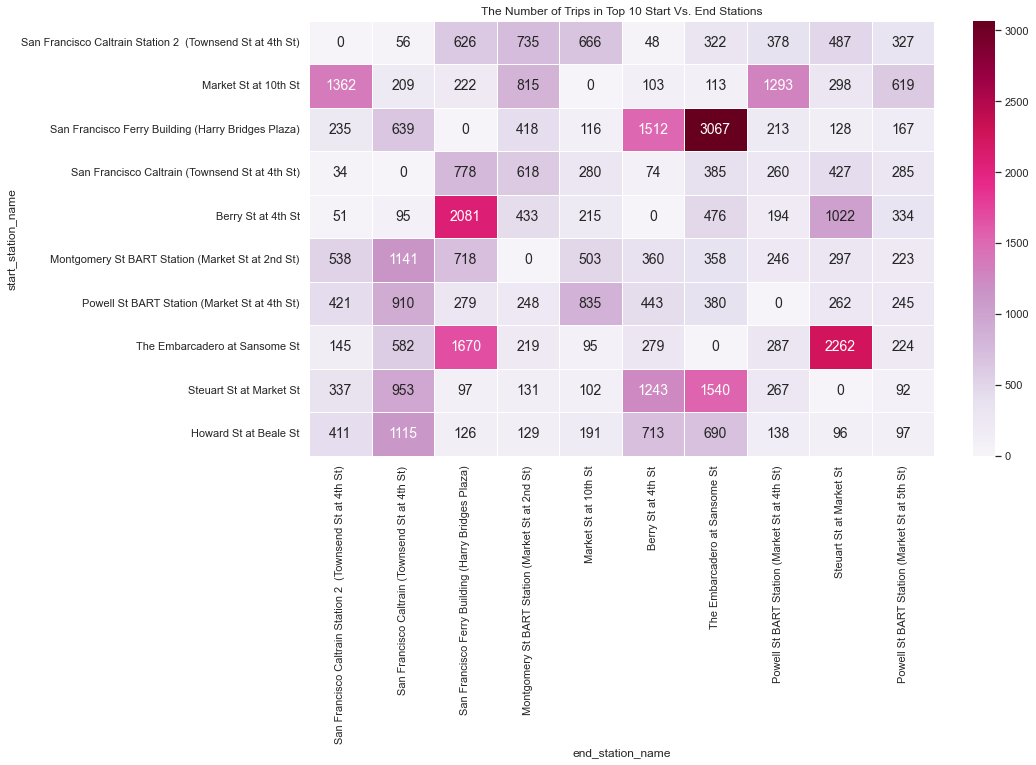

In [21]:
# Plotting a heatmap for trip counts in top 10 start Vs. end stations:
plt.figure(figsize=(14, 8))
g = sns.heatmap(data=matrix_, cmap='PuRd', linewidth=1,
                annot=True, fmt='.0f', annot_kws={'fontsize': 14})
g.set(title='The Number of Trips in Top 10 Start Vs. End Stations');

> - Top 5 are:
>> 1. San Francisco Ferry Building (Harry Bridges Plaza) >>> The Embarcadero at Sansome St.
>> 2. The Embarcadero at Sansome St >>> Steuart St at Market St.
>> 3. Berry St at 4th St >>> San Francisco Ferry Building (Harry Bridges Plaza).
>> 4. The Embarcadero at Sansome St >>> San Francisco Ferry Building (Harry Bridges Plaza).
>> 5. Steuart St at Market St >>> The Embarcadero at Sansome St.

## Which are the famous routes?
### (After dropping duplicates)

In [22]:
# Creating a matrix for start stations vs end stations:
strt_end_st_trip_counts = df.pivot_table(index='start_station_name', columns='end_station_name',
                                         values='user_type', aggfunc='count', fill_value=0)

In [23]:
# Defining a function to count each trip using the matrix:
def avoid_duplicates(trip):
    
    """
    This function searches for trip counts in both directions start >> end and end >> start.
    
    Args:
    (str): The trip.
    
    Returns:
    (int): The corrected count.
    """
    
    st_1, st_2 = trip.split(' | ')
    return strt_end_st_trip_counts.loc[st_1, st_2] + strt_end_st_trip_counts.loc[st_2, st_2]

In [24]:
# Creating a dataframe with a single column (trips):
top_trips = pd.DataFrame(df['trip'].value_counts(ascending=False).head(50).index.to_list())
top_trips.rename(columns=lambda x: 'trip', inplace=True)

In [25]:
# Populating the dataframe with a second column for the count of each trip:
top_trips['counts'] = top_trips['trip'].apply(avoid_duplicates)

In [26]:
# Dropping duplicated trips:
top_trips.drop_duplicates(subset='counts', inplace=True)
top_trips.sort_values(by='counts', ascending=False, inplace=True)

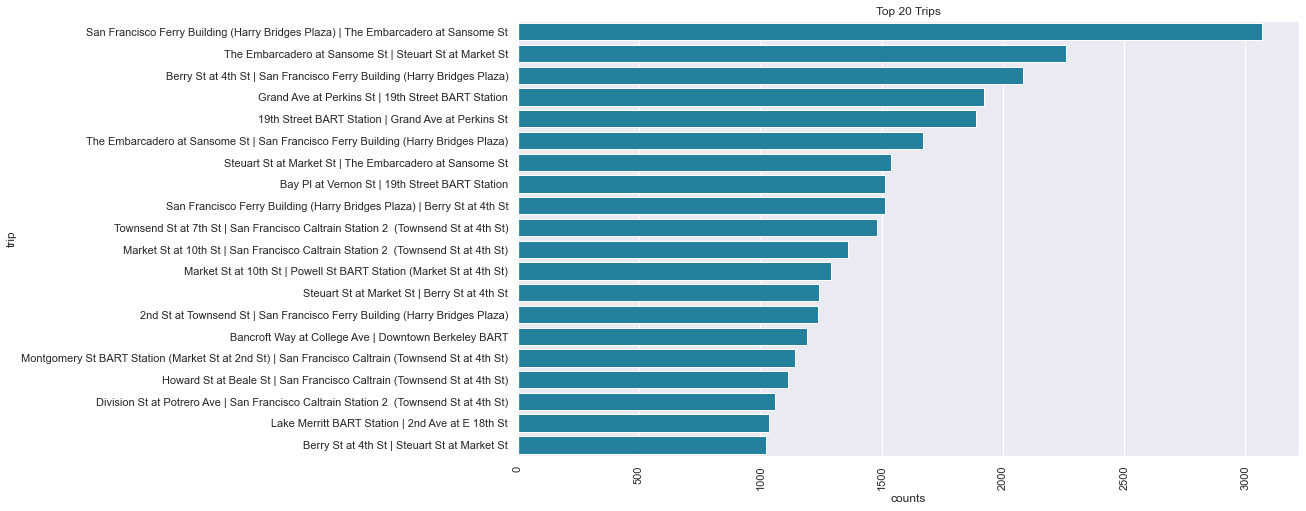

In [27]:
# Plotting the top 20 trips:
plt.figure(figsize=(14, 8))
plt.title('Top 20 Trips')
plt.xticks(rotation=90)
g = sns.barplot(data=top_trips.head(20), y='trip', x='counts', color=blue);

> - Top 10 trips:
>> 1. San Francisco Ferry Building (Harry Bridges Plaza) | The Embarcadero at Sansome St.
>> 2. The Embarcadero at Sansome St | Steuart St at Market St.
>> 3. Berry St at 4th St | San Francisco Ferry Building (Harry Bridges Plaza).
>> 4. Grand Ave at Perkins St | 19th Street BART Station.
>> 5. 19th Street BART Station | Grand Ave at Perkins St.
>> 6. The Embarcadero at Sansome St | San Francisco Ferry Building (Harry Bridges Plaza).
>> 7. Steuart St at Market St | The Embarcadero at Sansome St.
>> 8. Bay Pl at Vernon St | 19th Street BART Station.
>> 9. San Francisco Ferry Building (Harry Bridges Plaza) | Berry St at 4th St.
>> 10. Townsend St at 7th St | San Francisco Caltrain Station 2  (Townsend St at 4th St).

## That is all!
### I hope you found that informative.

In [28]:
!jupyter nbconvert slide_deck_ford_gobike.ipynb --to slides --no-input

[NbConvertApp] Converting notebook slide_deck_ford_gobike.ipynb to slides
[NbConvertApp] Writing 1645722 bytes to slide_deck_ford_gobike.slides.html
